# Grover's Algorithm for Binary Sudoku

The oracle checks if the solution is a correct Sudoku instance.

![sudoku](binary_sudoku.png)

In [1]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram

In [2]:
def xor(qc: QuantumCircuit, q1: int, q2: int, output: int):
    qc.cx(q1, output)
    qc.cx(q2, output)

In [3]:
def sudoku_oracle():
    qr_in = QuantumRegister(4, 'in')
    qr_tmp = QuantumRegister(4, 'tmp')
    qr_out = QuantumRegister(1, 'out')

    qc = QuantumCircuit(qr_in, qr_tmp, qr_out)

    # XOR
    xor(qc, qr_in[0], qr_in[1], qr_tmp[0])
    xor(qc, qr_in[2], qr_in[3], qr_tmp[1])
    xor(qc, qr_in[0], qr_in[2], qr_tmp[2])
    xor(qc, qr_in[1], qr_in[3], qr_tmp[3])

    # AND all the results
    qc.mcx(qr_tmp, qr_out)

    # Uncompute using XOR
    xor(qc, qr_in[0], qr_in[1], qr_tmp[0])
    xor(qc, qr_in[2], qr_in[3], qr_tmp[1])
    xor(qc, qr_in[0], qr_in[2], qr_tmp[2])
    xor(qc, qr_in[1], qr_in[3], qr_tmp[3])

    U = qc.to_gate()
    U.name = "$U_\chi$"
    return U

In [11]:
def reflect_zero(nqubits: int):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
    qc.h(nqubits - 1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # We will return the diffuser as a gate
    U_0 = qc.to_gate()
    U_0.name = "$U_0$"
    return U_0

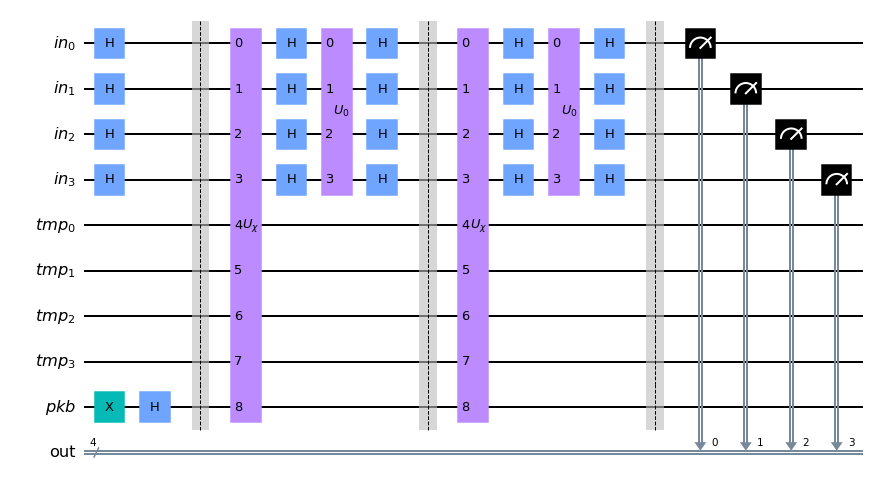

In [12]:
qr_in = QuantumRegister(4, 'in')
qr_tmp = QuantumRegister(4, 'tmp')
qr_pkb = QuantumRegister(1, 'pkb')
output = ClassicalRegister(4, 'out')

qc = QuantumCircuit(qr_in, qr_tmp, qr_pkb, output)

# prepare initial state
qc.h(qr_in)

# phase-kickback trick (S_\chi)
qc.x(qr_pkb)
qc.h(qr_pkb)

qc.barrier()

for i in range(2):
    # S_\chi
    qc.append(
        sudoku_oracle(),
        [qr_in[0], qr_in[1], qr_in[2], qr_in[3], qr_tmp[0], qr_tmp[1], qr_tmp[2], qr_tmp[3], qr_pkb[0]]
    )
    # A^-1
    qc.h(qr_in)
    # S_0
    qc.append(reflect_zero(4), qr_in)
    # A
    qc.h(qr_in)

    qc.barrier()

qc.measure(qr_in, output)
qc.draw("mpl", fold=-1)

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')

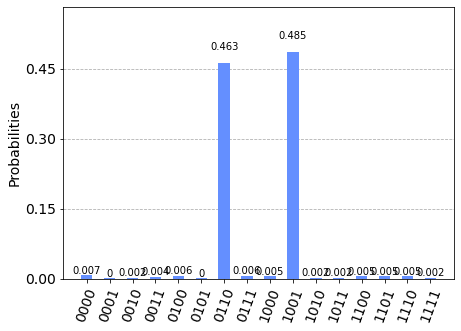

In [7]:
results = qasm_sim.run(transpile(qc, qasm_sim)).result()
counts = results.get_counts()
plot_histogram(counts)